In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
from collections import defaultdict

import ulfy
import matplotlib.pyplot as plt
import sympy as sp
from dolfin import *

from multirat.boundary import RobinBoundary, DirichletBoundary
from multirat.meshprocessing import Domain
from multirat.multicompartment import solve_pressure

def pressure_functionspace(mesh, degree, compartments):
    P1 = FiniteElement("CG", mesh.ufl_cell(), degree)
    el = MixedElement([P1] * len(compartments))
    return FunctionSpace(mesh, el)

def assign_mixed_function(p, V, compartments):
    P = Function(V)
    subspaces = [V.sub(idx).collapse() for idx, _ in enumerate(compartments)]
    Ptrue_int = [interpolate(p[j], Vj) for j, Vj in zip(compartments, subspaces)]
    assigner = FunctionAssigner(V, subspaces)
    assigner.assign(P, Ptrue_int)
    return P

def mms_domain(N, subboundaries):
    mesh = RectangleMesh(Point(-1, -1), Point(1, 1), N, N)
    boundary_tags = MeshFunction("size_t", mesh, dim=1, value=0)
    for tag, subd in subboundaries.items():
        subd.mark(boundary_tags, tag)
    return Domain(mesh, None, boundary_tags)


def quadratic_mms(a: float, p0: float, degree: int):
    x, y = sp.symbols("x y")
    p_sym =  a * (x**2 + y**2) + p0
    return p_sym
    mesh_ = UnitSquareMesh(1, 1)
    V_ = FunctionSpace(mesh_, "DG", 0)
    p_ = Function(V_)
    return ulfy.Expression(p_, subs={p_: p_sym}, degree=degree)


def quadratic_mms(a: float, p0: float, degree: int):
    x, y = sp.symbols("x y")
    p_sym =  a * (x**2 + y**2) + p0
    return p_sym
    mesh_ = UnitSquareMesh(1, 1)
    V_ = FunctionSpace(mesh_, "CG", degree)
    p_ = Function(V_)
    return ulfy.Expression(p_, subs={p_: p_sym}, degree=degree)


def expr(exp, degree):
    mesh_ = UnitSquareMesh(1, 1)
    V_ = FunctionSpace(mesh_, "CG", degree)
    v = Function(V_)
    return ulfy.Expression(v, subs={v: exp}, degree=degree)

def mms_parameters():
    K = defaultdict(lambda: 1.0)
    gamma = defaultdict(lambda: 1.0)
    L_bdry = defaultdict(lambda: 1.0)
    parameters = {
        "hydraulic_conductivity": K,
        "convective_fluid_transfer": gamma,
        "hydraulic_conductivity_bdry": L_bdry,
    }
    return parameters

def strong_form(p, K, gamma, degree):
    mesh_ = UnitSquareMesh(1, 1)
    V_ = FunctionSpace(mesh_, "CG", degree)
    p_ = {j: Function(V_) for j in compartments}
    transfer = {j: sum([gamma[(i, j)] * (p_[i] - p_[j]) for i in p if i != j]) for j in p}
    f = {j: -K[j] * div(grad(p_[j])) - transfer[j] for j in p}
    return {i: ulfy.Expression(f[i], subs={p_[j]: p[j] for j in p}, degree=degree) for i in p}


def mms_robin_boundary(pj, alpha, normals, degree):
    mesh_ = UnitSquareMesh(1, 1)
    V_ = FunctionSpace(mesh_, "CG", degree)
    p_ = Function(V_)
    
    gR = {tag: p_ + 1.0 / alpha * inner(grad(p_), n) for tag, n in normals.items()}
    gR = {tag: ulfy.Expression(gR[tag], subs={p_: pj}, degree=degree) for tag in gR}
    return [RobinBoundary(alpha, gR[tag], tag) for tag in gR]


def mms_dirichlet_boundary(pj, degree):
    mesh_ = UnitSquareMesh(1, 1)
    V_ = FunctionSpace(mesh_, "CG", degree)
    p_ = Function(V_)
    return [DirichletBoundary(expr(pj, degree), "everywhere")]


def expr(exp, degree):
    mesh_ = UnitSquareMesh(1, 1)
    V_ = FunctionSpace(mesh_, "CG", degree)
    v = Function(V_)
    return ulfy.Expression(v, subs={v: exp}, degree=degree)

def test_solver():
    normals = {1: Constant((-1, 0)), 2: Constant((1, 0)), 3: Constant((0, -1)), 4: Constant((0, 1))}
    subdomains = {1: CompiledSubDomain('near(x[0], -1)'),
                  2: CompiledSubDomain('near(x[0], 1)'),
                  3: CompiledSubDomain('near(x[1], -1)'),
                  4: CompiledSubDomain('near(x[1], 1)')}


    parameters = mms_parameters()
    K = parameters["hydraulic_conductivity"]
    gamma = parameters["convective_fluid_transfer"]
    L_bdry = parameters["hydraulic_conductivity_bdry"]

    compartments = ["pa", "pc", "pv"]    
    a = {"e": 0.5, "pa": 1.0, "pc": Constant(0.0), "pv": -1.0}
    p0 = defaultdict(lambda: 0.0)
    p = {j: quadratic_mms(a[j], p0[j], degree=2) for j in compartments}
    p_expr = {i: expr(p[i], degree=2) for i in p}

    f = strong_form(p, K, gamma, degree=2)
    boundaries = {
        "pa": mms_robin_boundary(p["pa"], -L_bdry["pa"] / K["pa"], normals, degree=2),
        "pc": [], # Homogeneous Neumann,
        "pv": mms_dirichlet_boundary(p["pv"], degree=2)
    }

    N = 10
    domain = mms_domain(N, subdomains)
    V = pressure_functionspace(domain.mesh, 2, compartments)
    Ph = solve_pressure(domain, V, compartments, boundaries, parameters, source=f)
    P = assign_mixed_function(p_expr, V, compartments)
    assert abs(P.vector()[:] - Ph.vector()[:]).max() < 1e-10
    
    vmin = Ph.vector().min()
    vmax = Ph.vector().max()
    for idx, j in enumerate(compartments):
        plt.title(j)
        c = plot(Ph.sub(idx), vmin=vmin, vmax=vmax)
        plt.colorbar(c)
        plt.show(False)
    sleep(5)

In [7]:
N = 10
domain = mms_domain(N, subdomains)
V = pressure_functionspace(domain.mesh, 2, compartments)
Ph = solve_pressure(domain, V, compartments, boundaries, parameters, source=f)
P = assign_mixed_function(p_expr, V, compartments)
assert abs(P.vector()[:] - Ph.vector()[:]).max() < 1e-10

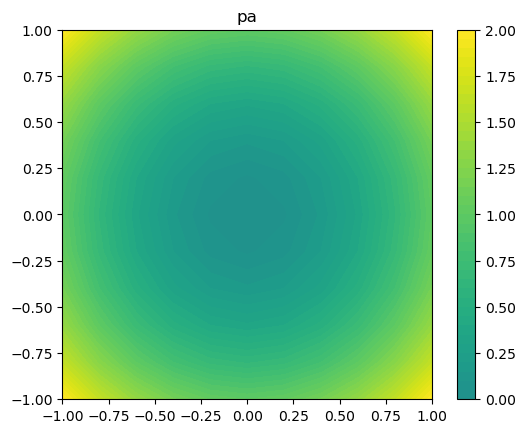

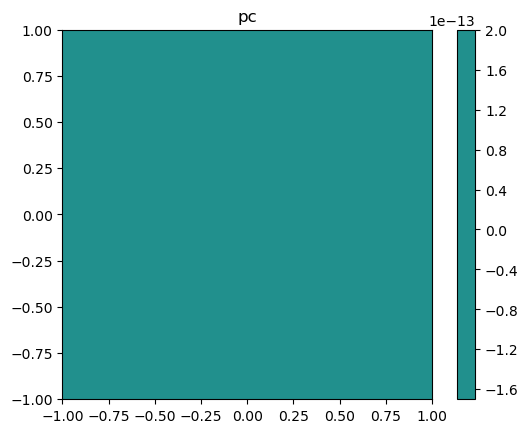

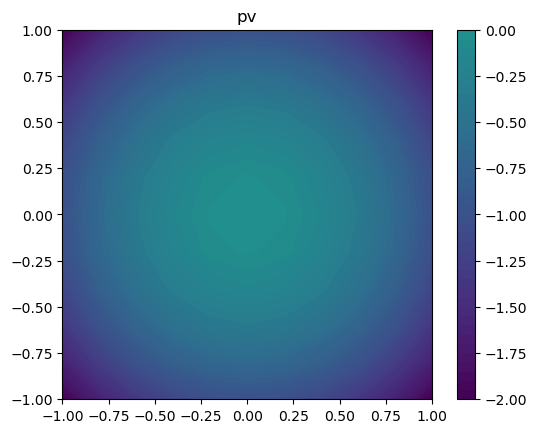

In [9]:
N = 10
mesh = RectangleMesh(Point(-1, -1), Point(1, 1), N, N)

vmin = Ph.vector().min()
vmax = Ph.vector().max()
for idx, j in enumerate(compartments):
    plt.title(j)
    c = plot(Ph.sub(idx), vmin=vmin, vmax=vmax)
    plt.colorbar(c)
    plt.show()

In [47]:
def test_solver():
    N = 2**5
    normals = {1: Constant((-1, 0)), 2: Constant((1, 0)), 3: Constant((0, -1)), 4: Constant((0, 1))}
    subdomains = {1: CompiledSubDomain('near(x[0], -1)'),
                  2: CompiledSubDomain('near(x[0], 1)'),
                  3: CompiledSubDomain('near(x[1], -1)'),
                  4: CompiledSubDomain('near(x[1], 1)')}
    domain  = mms_domain(N, subdomains)
    
    compartments = ["pa", "pc", "pv"]    
    a = {"e": 0.5, "pa": 1.0, "pc": Constant(0.0), "pv": -1.0}
    p0 = defaultdict(lambda: 0.0)
    p = {j: quadratic_mms(a[j], p0[j], degree=4) for j in compartments}
    
    
    boundaries = mms_boundaries(p)
    
    V = pressure_functionspace(domain.mesh, degree=2, compartments=compartments)
    P = assign_mixed_function(p, V, compartments)

    parameters = mms_parameters()
    Ph = solve_pressure(domain, V, compartments, boundaries, params, source=None)
    
    vmin = Ph.vector().min()
    vmax = Ph.vector().max()
    fig = plt.figure()
    for idx, j in enumerate(compartments):
        fig.add_subplot(2, 2, idx+1)
        c = plot(Ph.sub(idx), vmin=vmin, vmax=vmax)
        plt.colorbar(c)
        plt.title(j)
    plt.show(False)
    sleep(5)
    assert abs(P.vector()[:] - ph.vector()[:]).max() < 1e8, ""

test_solver()

NameError: name 'mms_boundaries' is not defined

In [ ]:
# Define unit normal vector of boundaries.
normals = {1: Constant((-1, 0)), 2: Constant((1, 0)), 3: Constant((0, -1)), 4: Constant((0, 1))}


# Define various subdomains.
subdomains = {1: CompiledSubDomain('near(x[0], -1)'),
              2: CompiledSubDomain('near(x[0], 1)'),
              3: CompiledSubDomain('near(x[1], -1)'),
              4: CompiledSubDomain('near(x[1], 1)')}

compartments = ["e", "pa", "pc", "pv"]

N = 2 ** 5
domain = mms_domain(N, subboundaries)

K = defaultdict(lambda: 1.0)
gamma = defaultdict(lambda: 1.0)
L_bdry = defaultdict(lambda: 1.0)
p0 = defaultdict(lambda: 0.0)

a = {"e": 0.5, "pa": 1.0, "pc": Constant(0.0), "pv": -1.0}
p = {j: a[j] * (x**2 + y**2) + p0[j] for j in compartments}

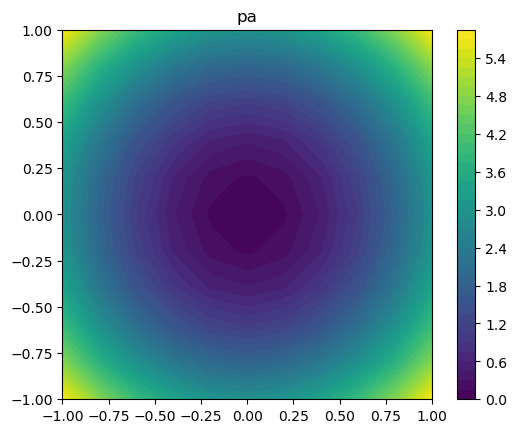

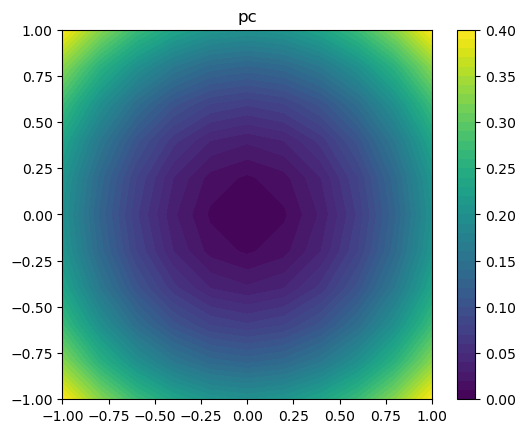

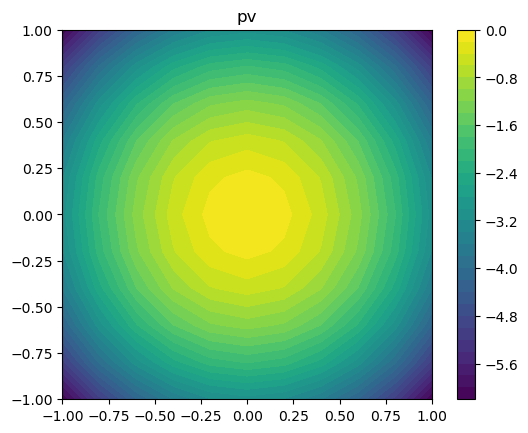

In [28]:
compartments = ["pa", "pc", "pv"]
a = {"e": 0.5, "pa": 1.0, "pc": Constant(0.0), "pv": -1.0}
p = {j: quadratic_mms(a[j], p0[j], degree=2) for j in compartments}

N = 10
mesh = RectangleMesh(Point(-1, -1), Point(1, 1), N, N)

for j in compartments:
    plt.title(j)
    c = plot(F[j], mesh=mesh)
    plt.colorbar(c)
    plt.show()

In [27]:
with XDMFFile("mms_domain.xdmf") as f:
    f.write(domain.boundaries)